In [1]:
import tkinter as tk
import pandas as pd
import math
import pandas as pd
import numpy as np
import cv2

import pygetwindow as gw
import pyautogui
import threading
import time

from PIL import Image, ImageStat
from matplotlib import pyplot as plt
from os.path import exists

In [2]:
### INVENTORY ITEM DETECTION ###

def edge_detection(img_np):
    img = cv2.cvtColor(img_np, cv2.COLOR_BGR2GRAY)
#     img = cv2.blur(img, (3,3))
    img = cv2.GaussianBlur(img, (3,3), 0)
    img = cv2.Canny(img, threshold1=50, threshold2=200, apertureSize=5)
#     img = cv2.blur(img, (2,2))
    img = cv2.blur(img, (3,3))
    return img

def inventory_line_detection(img):
    img_inventory_edge = edge_detection(img)
    
    img_horizontal = img_inventory_edge.copy()
    img_vertical = img_inventory_edge.copy()

    line_length = 50
    horizontal_struct = cv2.getStructuringElement(cv2.MORPH_RECT, (line_length,1))
    vertical_struct = cv2.getStructuringElement(cv2.MORPH_RECT, (1,line_length))

    cv2.erode(img_horizontal, horizontal_struct, img_horizontal)
    cv2.dilate(img_horizontal, horizontal_struct, img_horizontal)

    cv2.erode(img_vertical, vertical_struct, img_vertical)
    cv2.dilate(img_vertical, vertical_struct, img_vertical)

    result = cv2.add(img_horizontal, img_vertical)
    return result

def find_slot_locations(inventory_filtered, slot_gray):
    global slot_locations, nr_valid_predictions
    
    matched_slots = cv2.matchTemplate(inventory_filtered, slot_gray, cv2.TM_CCORR_NORMED)
    
    threshold = 0.7
    slots_min_x = (int) (1920/3)
    min_distance = 50
    slots = []
    
    for y in range(matched_slots.shape[0]):
        for x in range(matched_slots.shape[1]):
            if matched_slots[y][x] > threshold:
                if x > slots_min_x:
                    slots.append((x,y))
    
    # filter number of locations
    valid_slots = 0
    for i,new_slot in enumerate(slots):
        add_slot = True
        x = new_slot[0]
        y = new_slot[1]
        for j in range(valid_slots):
            s = slot_locations[j]
            if abs(s[0]-x) < min_distance and abs(s[1]-y) < min_distance:
                add_slot = False
                break
        if add_slot == True:
            slot_locations[valid_slots] = (x,y)
            valid_slots += 1
    
    nr_valid_predictions = valid_slots

def draw_slots_on_image(img, slots):
    img_with_slots = img.copy()
    for x,y in slots:
        img_with_slots = cv2.circle(img_with_slots, (x, y), radius=5, color=(255,0,0), thickness=-1)
    return img_with_slots

def get_item_images_from_inventory(inventory):
    global item_images, max_items_to_predict, item_images_updated
    global slot_locations, nr_valid_predictions
    
    slot_size = 64 # in pixels, for FHD resolution TODO
    for i in range(nr_valid_predictions):
        s = slot_locations[i]
        item_images[i] = inventory[s[1]:s[1]+slot_size, s[0]:s[0]+slot_size]
        
    item_images_updated = True



### ITEM PREDICTION ###

def load_icons_from_disk(verbose=False):
    global all_items_df
    
    icons = []
    for index,item in all_items_df.iterrows():
        filename = path_grid_icons + item['id'] + filename_ending_grid_icon
        if exists(filename):
            icons.append(np.asarray(Image.open(filename)))
        else:
            icons.append([])
            if verbose:
                print(f"File {filename} does not exist.")
    return icons

def run_sift(img):
    global sift
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    kp,des = sift.detectAndCompute(gray,None)
    return kp,des

def create_all_descriptors():
    global icons
    descriptors = []
    for icon in icons:
        if len(icon) == 0:
            descriptors.append(None)
            continue
        kp,des = run_sift(icon)
        descriptors.append(des)
    return descriptors

def predict_icon(img):
    global icons, bf, descriptors
    distances = []
    
    kp,des = run_sift(img)

    for i in range(len(icons)):
        if descriptors[i] is None:
            distances.append(999999)
            continue

        matches = bf.match(des, descriptors[i])

        distance = 0
        for match in matches:
            distance += (match.distance**2)/len(matches)
        distances.append(distance)

    prediction = np.argmin(distances)
    min_distance = min(distances)
    
    # filter predictions
#     threshold = 60000
#     if min_distance > threshold:
#         return -1,-1
    
    return prediction,min_distance

def predict_all_icons(images, predictions, distances):
    for item in images:
        p,d = predict_icon(item)
        predictions.append(p)
        distances.append(d)
        
def predict_current_inventory(predictions_df):
    # get inventory
    screenshot = pyautogui.screenshot(region=(window_tarkov_position[0],window_tarkov_position[1]
                                              , window_tarkov_size[0], window_tarkov_size[1]))
    screenshot = np.array(screenshot)
    
    # get items from screenshot
    get_predictions_from_inventory(screenshot)

In [3]:
def threaded_prediction(items):
    global item_images_updated, nr_valid_predictions, predictions_updated
    global predictions_df, slot_locations
    global predictions, distances
    
    while True:
        if not item_images_updated:
            time.sleep(1)
            print("Thread running...")
        else:
            print(f"we have {nr_valid_predictions} new predictions")
            for i in range(nr_valid_predictions):
                item = item_images[i]

                # update prediction information
                p,d = predict_icon(item)
                predictions[i] = p
                distances[i] = d

                # update prediction dataframe
                predictions_df.loc[i,'slot_x'] = slot_locations[i][0]
                predictions_df.loc[i,'slot_y'] = slot_locations[i][1]

                predictions_df.loc[i,'predicted_item'] = predictions[i]
                predictions_df.loc[i,'distance'] = distances[i]

            predictions_updated = True
        
# def threaded_prediction_df_update(predictions_df, predictions, distances):
#     length = 0
#     while length < len(predictions_df):
#         for i in range(length):
#             if not predictions_df.loc[i,'predicted_item'] is None:
#                 continue
#             predictions_df.loc[i,'predicted_item'] = predictions[i]
#             predictions_df.loc[i,'distance'] = distances[i]
#         time.sleep(0.1)
#         length = min(len(predictions),len(distances))
                 
#     # check if all values are written
#     for i in range(len(predictions_df)):
#         if not predictions_df.loc[i,'predicted_item'] is None:
#             continue
#         predictions_df.loc[i,'predicted_item'] = predictions[i]
#         predictions_df.loc[i,'distance'] = distances[i]

In [4]:
def get_predictions_from_inventory(inventory):
    global img_slot_gray
    global thread_predict
    
    # get item images
    t0 = time.time()
    inventory_filtered = inventory_line_detection(inventory)
    find_slot_locations(inventory_filtered, img_slot_gray)
    get_item_images_from_inventory(inventory)
    t1 = time.time()
    print(f'inventory took {t1-t0} s')
    
    # predict each item from inventory
    ## thread is already doing this

    t2 = time.time()
    print(f'item predictions took {t2-t1} s')
    return predictions_df

# setup items, icons and descriptors

In [5]:
# paths
path_icons = './icons/'
path_images = './images/'
path_grid_icons = './grid_icons/'
path_data = './data/'

filename_ending_grid_icon = '-grid-image.jpg'

window_title_tarkov = 'EscapeFromTarkov'

In [6]:
icons = []
descriptors = []
all_items_df = None

max_items_to_predict = 300
nr_valid_predictions = 0
predictions_df = None
item_images = []
predictions = []
distances = []
slot_locations = []

img_slot_gray = None

root = None
price_labels = []

item_images_updated = False
predictions_updated = False
thread_predict = threading.Thread(target=threaded_prediction, args=(item_images,))

sift = cv2.SIFT_create()
bf = cv2.BFMatcher()

In [7]:
# get needed data
all_items_df = pd.read_csv(path_data + 'all_items.csv')
icons = load_icons_from_disk()
descriptors = create_all_descriptors()

In [8]:
# load and filter slot reference image
img_slot = Image.open(path_images + 'slot_empty.png')
img_slot = np.asarray(img_slot)
img_slot_gray = cv2.cvtColor(img_slot, cv2.COLOR_BGR2GRAY)

In [9]:
# initialize arrays
predictions_df = pd.DataFrame({'slot_x': [0] * max_items_to_predict, 'slot_y': [0] * max_items_to_predict
        , 'predicted_item': [-1] * max_items_to_predict, 'distance': [0] * max_items_to_predict})
price_labels = [None] * max_items_to_predict
item_images = [None] * max_items_to_predict
predictions = [-1] * max_items_to_predict
distances = [0] * max_items_to_predict
slot_locations = [(0,0)] * max_items_to_predict

In [10]:
# start prediction thread
thread_predict.start()

# get inventory from tarkov

In [11]:
# get tarkov window
window_tarkov = gw.getWindowsWithTitle(window_title_tarkov)[0]
window_tarkov_position = window_tarkov.topleft
window_tarkov_size = window_tarkov.size

In [12]:
# get items from screenshot
predict_current_inventory(predictions_df)

Thread running...
Thread running...
Thread running...
Thread running...
inventory took 4.20855712890625 s
item predictions took 0.0 s


In [13]:
predictions_df

,slot_x,slot_y,predicted_item,distance
0,0,0,-1,0
1,0,0,-1,0
2,0,0,-1,0
3,0,0,-1,0
4,0,0,-1,0
...,...,...,...,...
295,0,0,-1,0
296,0,0,-1,0
297,0,0,-1,0
298,0,0,-1,0


# create overlay with predictions

In [14]:
def place_label(text, x, y, index):
    global root
    
    label = tk.Label(root, text=text, font=("helvetica", 30), fg='white', bg='black')
    label.place(x=x, y=y, anchor = 'nw')
    
    # remove old label
    if index < len(price_labels):
        price_labels[index].destroy()
        price_labels[index] = label
    else:
        price_labels.append(label)
    
def create_overlay():
    root = tk.Tk()
    root.title("window title")
    root.geometry("1920x1080+%d+%d" % (x_window,y_window))
    root.attributes('-topmost', True)
    root.overrideredirect(True)
    root.configure(bg='red')

    # make color red transparent
    root.wm_attributes('-transparentcolor', 'black')
    return root

def update_price_labels():
#     remove_price_labels()
    add_price_labels()

def add_price_labels():
    global nr_valid_predictions
    
    for i in range(nr_valid_predictions):
        prediction = predictions_df.loc[i]
        index = prediction[2]
        if index is None:
            break
            
        x = prediction[0]
        y = prediction[1]
        price_flea = all_items_df.loc[index, 'fleaMarket']

        if math.isnan(price_flea):
            continue
        price = (int) (all_items_df.loc[index, 'fleaMarket']/1000)
        price_string = str(price) + 'k'
        place_label(price_string, x, y, i)
    
    # remove other labels
    for i in range(nr_valid_predictions, len(price_labels)):
        if price_labels[i] is None:
            break
        price_labels[i].destroy()

def remove_price_labels():
    for label in price_labels:
        label.destroy()
        
def update(update_counter):
    global predictions_df
    
    if update_counter >= 40:
        update_counter = 0
    update_price_labels()
    
    # run itself again after 1000 ms
    root.after(200, update, update_counter+1)

In [15]:
prediction = predictions_df.loc[5]
prediction

slot_x            0
slot_y            0
predicted_item   -1
distance          0
Name: 5, dtype: int64

In [16]:
# find overlay position
x_window = window_tarkov_position[0]
y_window = window_tarkov_position[1]

# create the window
root = create_overlay()

# create a transparent frame to make a border
my_frame = tk.Frame(root, width=1900, height=1060, bg='black')
my_frame.place(x=10,y=10)

In [17]:
# add all item prices
price_labels = []
update(0)

Thread running...
we have 112 new predictions


KeyError: -1

In [ ]:
# show the window and take focus
root.focus_force()
root.bind('<Escape>', lambda e: root.destroy())
root.mainloop()

we have 112 new predictions
we have 112 new predictions


In [19]:
predictions_df

In [22]:
price_labels = []

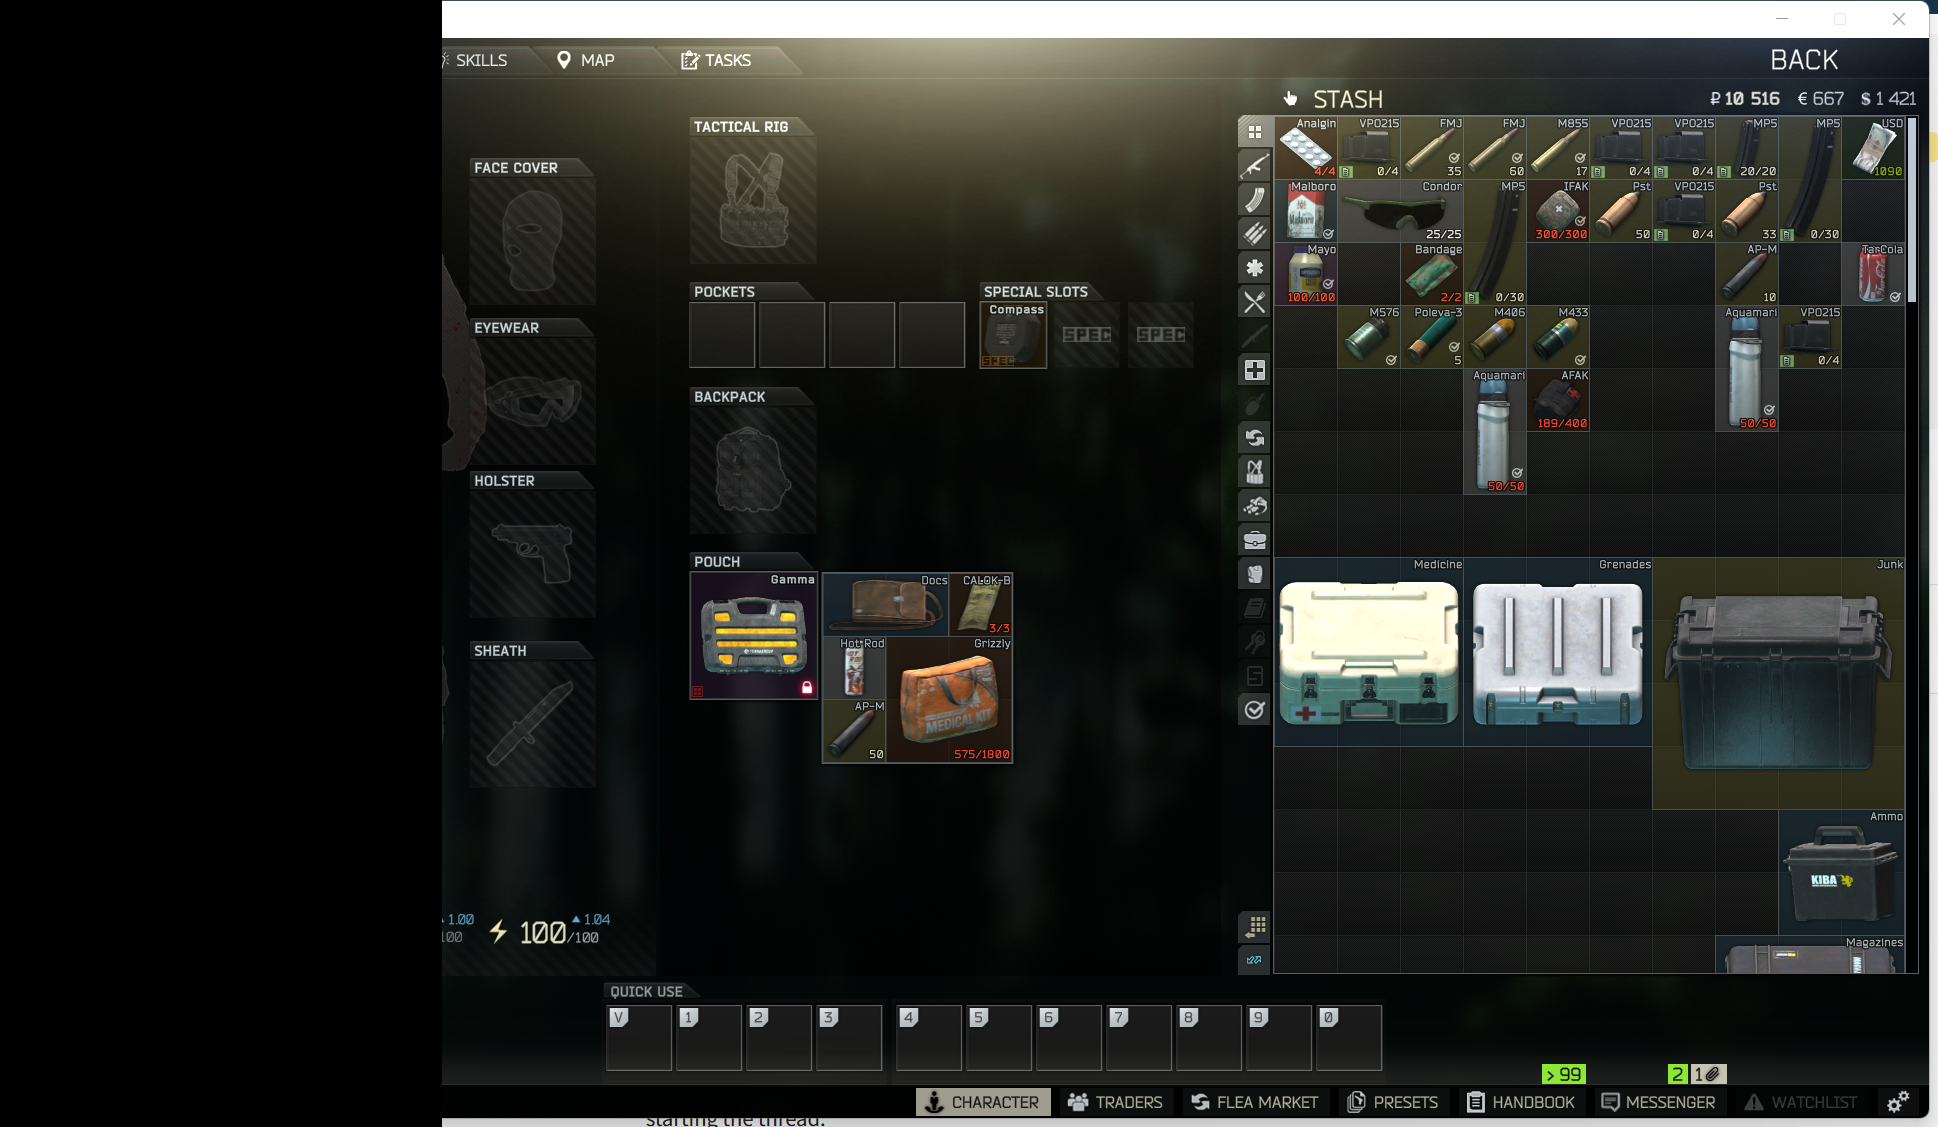

In [13]:
Image.fromarray(screenshot)

In [4]:
text_index = 1
texts = ['This is a label.', 'New text.']

def changeText():
    global text_index
    label['text'] = texts[text_index]
    text_index = -text_index + 1

In [12]:
a = [1,2,3,4]
for i,b in enumerate(a):
    print(i,b)

0 1
1 2
2 3
3 4


In [19]:




# # add a label
# label = tk.Label(root, text="This is a label.", font=("helvetica", 30), fg='white', bg='black')
# label.place(x=50, y=50, anchor = 'nw')

# # add a button
# button = tk.Button(root, text='Change the text', command=changeText)
# button.pack()







In [20]:
all_items_df.loc[1384]

name                Mystery Ranch Blackjack 50 backpack (Multicam)
id                                        5c0e774286f77468413cc5b2
width                                                            5
height                                                           7
icon_width                                                    63.0
icon_height                                                   63.0
features                                                        []
fleaMarket                                                     NaN
flea_avg48                                                       0
flea_ch48percent                                               NaN
prapor                                                         NaN
therapist                                                      NaN
fence                                                      35200.0
skier                                                      43120.0
peacekeeper                                                   

In [15]:
gw.getWindowsWithTitle(window_title_tarkov)[0]

Win32Window(hWnd=529062)

In [10]:
gw.getAllTitles()

['',
 'NVIDIA GeForce Overlay DT',
 'overlay - Jupyter Notebook — Mozilla Firefox',
 'EscapeFromTarkov',
 'slotDetection - Jupyter Notebook — Mozilla Firefox',
 '',
 '',
 'Windows PowerShell',
 'C:\\Users\\Michael\\Desktop\\tarkovRat\\images',
 '',
 'PyGetWindow · PyPI — Mozilla Firefox',
 'Escape From Tarkov - Discord',
 'Settings',
 'Settings',
 'Steam',
 'NVIDIA GeForce Overlay',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 'Program Manager']

In [8]:
gw.getAllWindows()

[Win32Window(hWnd=135370),
 Win32Window(hWnd=66382),
 Win32Window(hWnd=529064),
 Win32Window(hWnd=529062),
 Win32Window(hWnd=722954),
 Win32Window(hWnd=659958),
 Win32Window(hWnd=2429160),
 Win32Window(hWnd=263238),
 Win32Window(hWnd=725272),
 Win32Window(hWnd=201324),
 Win32Window(hWnd=329698),
 Win32Window(hWnd=135444),
 Win32Window(hWnd=132228),
 Win32Window(hWnd=198084),
 Win32Window(hWnd=66844),
 Win32Window(hWnd=66376),
 Win32Window(hWnd=65960),
 Win32Window(hWnd=65950),
 Win32Window(hWnd=131270),
 Win32Window(hWnd=65908),
 Win32Window(hWnd=65906),
 Win32Window(hWnd=65904),
 Win32Window(hWnd=65902),
 Win32Window(hWnd=65768),
 Win32Window(hWnd=201080),
 Win32Window(hWnd=262570),
 Win32Window(hWnd=65846)]

In [35]:
all_items_df

,name,id,width,height,icon_width,icon_height,features,fleaMarket,flea_avg48,flea_ch48percent,prapor,therapist,fence,skier,peacekeeper,mechanic,ragman,jaeger
0,Colt M4A1 5.56x45 assault rifle,5447a9cd4bdc2dbd208b4567,1,1,316.0,127.0,"[(23, 25, 25)]",55000.0,80823,-45.34,9198.0,NaN,7358.0,NaN,84.0,10302.0,NaN,NaN
1,5.56x45mm M855 ammo pack (30 pcs),5447ac644bdc2d6c208b4567,1,1,64.0,64.0,"[(77, 80, 67)]",10000.0,0,0.00,NaN,NaN,400.0,NaN,NaN,NaN,NaN,NaN
2,Factory emergency exit key,5448ba0b4bdc2d02308b456c,1,1,64.0,64.0,"[(58, 52, 62)]",66888.0,81146,-3.46,25000.0,31500.0,20000.0,NaN,NaN,NaN,NaN,NaN
3,Makarov PM 9x18PM pistol,5448bd6b4bdc2dfc2f8b4569,2,1,63.0,64.0,[],6000.0,8814,11.72,2548.0,NaN,2038.0,NaN,23.0,2854.0,NaN,NaN
4,RGD-5 hand grenade,5448be9a4bdc2dfd2f8b456a,1,1,64.0,64.0,"[(36, 39, 37)]",11821.0,13412,-6.80,3615.0,NaN,2892.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2718,Oakley SI Batwolf glasses,62a61c988ec41a51b34758d5,2,1,63.0,64.0,[],16888.0,26974,0.37,NaN,NaN,7200.0,8820.0,82.0,NaN,11160.0,NaN
2719,Rogue USEC barrack key,62a9cb937377a65d7b070cef,1,1,64.0,64.0,"[(51, 61, 68)]",33333.0,35070,-3.51,20000.0,25200.0,16000.0,NaN,NaN,NaN,NaN,NaN
2720,Dogtag,customdogtags12345678910,1,1,64.0,64.0,"[(62, 70, 76)]",NaN,0,NaN,300.0,378.0,240.0,294.0,NaN,NaN,NaN,NaN
2721,Glock 17 9x19 pistol PS9,glock17ps900000000000001,2,1,63.0,64.0,[],NaN,0,0.00,29554.0,NaN,23643.0,NaN,269.0,33100.0,NaN,NaN
